In [1]:
import os
import shutil
import pandas as pd
import numpy as np
import glob
from glob import iglob
from pathlib import Path
import cv2
import random

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as tfl

import sklearn
import matplotlib.pyplot as plt

In [117]:
#some constants
img_size=128
batch_size=32
base_learning_rate = 0.0005
num_classes=2
metadata_path = '/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Coughvid-dataset/metadata_compiled.csv'
class1_path = '/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Coughvid-dataset/images1/Class_1'
class2_path = '/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Coughvid-dataset/images1/Class_2'
images_path = '/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Coughvid-dataset/images1'
images_test_set_path = '/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Coughvid-dataset/images1_test_set'

In [118]:
data_dir = class2_path

#load meta data
metadata = pd.read_csv(metadata_path)

metadata.count

#count how many of each class
nan_ctr = 0
healthy_ctr = 0
symptomatic_ctr = 0
COVID_ctr = 0

accum_data = pd.DataFrame()
for x in os.listdir(data_dir):
    if x.endswith('.png'):
        path_object = Path(x)
        #print(path_object.stem)
        q=metadata.loc[metadata['uuid']==path_object.stem]
        #print(q['status'].values[0])
        tmp = q['status'].values[0]

        if tmp == 'healthy':
            healthy_ctr += 1
        if tmp == 'symptomatic':
            symptomatic_ctr += 1
        if tmp == 'COVID-19':
            COVID_ctr += 1
            
            
print('nan: ', nan_ctr)
print('healthy: ', healthy_ctr)
print('symptomatic: ', symptomatic_ctr)
print('Covid: ', COVID_ctr)




nan:  0
healthy:  0
symptomatic:  2321
Covid:  1034


In [16]:
metadata['status'].value_counts()

healthy        12479
symptomatic     2590
COVID-19        1155
Name: status, dtype: int64

In [ ]:
create_test_set_directory = False

#create test set directory
if create_test_set_directory:
    
    path = '/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Coughvid-dataset/images_copy/Symptomatic'
    dest_path = '/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Coughvid-dataset/images_test_set_copy/Symptomatic'

    files = [f for f in glob.glob(path + "**/*.png", recursive=True)]

    for f in files:
        r = random.randrange(1,100)
        if(r<=10):
            basename = os.path.basename(f)
            file_name = os.path.splitext(basename)[0]
            file_destination = os.path.join(dest_path , file_name + '.png')
            print('moving ' + f + ' to ' + file_destination)
            shutil.move(f, file_destination)
        

In [75]:
copy_samples = False

if copy_samples:

    #copy 'symptomatic' samples to training and test folder

    training_source = '/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Coughvid-dataset/images_copy/Symptomatic'
    test_source = '/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Coughvid-dataset/images_test_set_copy/Symptomatic'

    training_dest = '/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Coughvid-dataset/images/Class_2'
    test_dest = '/Users/rogierlandman/from_Samsung/Machine_learning_datasets/Coughvid-dataset/images_test_set/Class_2'

    files=os.listdir(training_source)

    # iterating over all the files in
    # the source directory
    for fname in files:

        # copying the files to the
        # destination directory
        shutil.copy2(os.path.join(training_source,fname), training_dest)


    files=os.listdir(test_source)

    # iterating over all the files in
    # the source directory
    for fname in files:

        # copying the files to the
        # destination directory
        shutil.copy2(os.path.join(test_source,fname), test_dest)



In [119]:
data_dir = images_path

#make training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred', 
    label_mode='int',
    color_mode='rgb',
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(img_size, img_size),
    crop_to_aspect_ratio=False,
    batch_size=batch_size)


#make validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred', 
    label_mode='int',
    color_mode='rgb',
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(img_size, img_size),
    crop_to_aspect_ratio=False,
    batch_size=batch_size)

test_set_directory = images_test_set_path

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_set_directory,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    shuffle=False,
    validation_split=None,
    subset=None,
    seed=42,
    image_size=(img_size, img_size),
    crop_to_aspect_ratio=False,
    batch_size=batch_size)




Found 14540 files belonging to 2 classes.
Using 11632 files for training.
Found 14540 files belonging to 2 classes.
Using 2908 files for validation.
Found 1684 files belonging to 2 classes.


In [132]:
#chosen_model = 'MobileNetV2'
chosen_model = 'Xception'
#chosen_model = 'OwnModel1'

if(chosen_model == 'Xception'):
    #Xception model
    base_model = keras.applications.Xception(
        weights="imagenet",  # Load weights pre-trained on ImageNet.
        input_shape=(img_size, img_size, 3),
        include_top=False,
    )  # Do not include the ImageNet classifier at the top.
    
    
    
if(chosen_model == 'MobileNetV2'):
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(img_size, img_size, 3),
        include_top=True,
        weights="imagenet",
    )    
    

In [136]:
if(chosen_model == 'Xception'):
    
     # Freeze the base_model
    base_model.trainable = False

    # Create new model on top
    inputs = keras.Input(shape=(img_size, img_size, 3))
    x = inputs  # Apply random data augmentation

    # Pre-trained Xception weights requires that input be scaled
    # from (0, 255) to a range of (-1., +1.), the rescaling layer
    # outputs: `(inputs * scale) + offset`
    scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
    x = scale_layer(x)

    # The base model contains batchnorm layers. We want to keep them in inference mode
    # when we unfreeze the base model for fine-tuning, so we make sure that the
    # base_model is running in inference mode here.
    x = base_model(x, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    #x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
    #x=keras.layers.Dense(1024,activation='relu')(x)
    #x=keras.layers.Dense(512,activation='relu')(x)
    
    
    #try this
    # flatten the output of the convolutional part: 
    x = keras.layers.Flatten()(x)
    # three hidden layers
    x = keras.layers.Dense(100, activation='relu')(x)
    x = keras.layers.Dense(100, activation='relu')(x)
    x = keras.layers.Dense(100, activation='relu')(x)
    # final softmax layer with two categories (dog and cat)
    #predictions = keras.layers.Dense(2, activation='softmax')(x)
    
    
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)

    model.summary()

    
    model.compile(
        optimizer=keras.optimizers.Adam(base_learning_rate),
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.AUC()],
    )
    
if(chosen_model == 'MobileNetV2'):
    
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=(img_size, img_size, 3),
                                               include_top=False,
                                               weights='imagenet')
    base_model.trainable = False
    inputs = tf.keras.Input(shape=(img_size, img_size, 3))
    #x = data_augmentation(inputs)
    x = preprocess_input(inputs)
    x = base_model(x, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(.2)(x)
    #x=keras.layers.Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
    #x=keras.layers.Dense(1024,activation='relu')(x) #dense layer 2
    #x=keras.layers.Dense(512,activation='relu')(x) #dense layer 3
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)
    # YOUR CODE ENDS HERE
    
    #outputs = prediction_layer(x) 
    model = keras.Model(inputs, outputs)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                   loss=tf.keras.losses.BinaryCrossentropy(),
                   metrics=[tf.keras.metrics.Recall()])

    
    
if(chosen_model == 'OwnModel1'):
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(32, (5, 5), input_shape=(img_size, img_size, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D())
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 rescaling_7 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 global_average_pooling2d_20  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_24 (Dense)            (None, 100)               204900    
                                                          

In [137]:
#from sklearn.utils import class_weight

#train_label = np.concatenate([y for x, y in train_ds], axis=0)

class_weights = {0: 1.,
                1: 3.}

#class_weights = class_weight.compute_class_weight('balanced', classes = np.unique(train_label), y = train_label)

In [138]:
epochs = 5

if(chosen_model == 'Xception'):
    history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, class_weight=class_weights)
    
if(chosen_model == 'MobileNetV2'):
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, class_weight=class_weights)

if(chosen_model == 'OwnModel1'):
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, class_weight=class_weights)

Epoch 1/5


/Users/rogierlandman/opt/anaconda3/envs/VoiceRec1/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


364/364 [==============================] - 261s 711ms/step - loss: 1.0132 - auc_3: 0.5060 - val_loss: 0.6964 - val_auc_3: 0.5285
Epoch 2/5
364/364 [==============================] - 265s 729ms/step - loss: 1.0064 - auc_3: 0.5347 - val_loss: 0.7140 - val_auc_3: 0.5440
Epoch 3/5
364/364 [==============================] - 267s 734ms/step - loss: 1.0025 - auc_3: 0.5469 - val_loss: 0.7028 - val_auc_3: 0.5359
Epoch 4/5
364/364 [==============================] - 279s 767ms/step - loss: 0.9978 - auc_3: 0.5644 - val_loss: 0.7001 - val_auc_3: 0.5385
Epoch 5/5
364/364 [==============================] - 304s 834ms/step - loss: 0.9909 - auc_3: 0.5830 - val_loss: 0.6918 - val_auc_3: 0.5240


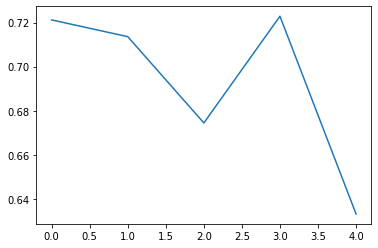

In [130]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_loss'])

In [131]:
import sklearn.metrics as metrics

predictions = model.predict(test_ds)
predictions = predictions.ravel()
predictions = np.int32(np.round(predictions))

test_label = np.concatenate([y for x, y in test_ds], axis=0)

confusion_matrix = metrics.confusion_matrix(test_label, predictions)
print(confusion_matrix)

F1 = metrics.f1_score(test_label, predictions)
print('F1 score: ', F1)

precision = metrics.precision_score(test_label, predictions)
print('precision: ', precision)

recall = metrics.recall_score(test_label, predictions)
print('recall: ', recall)


[[1024  270]
 [ 294   96]]
F1 score:  0.25396825396825395
precision:  0.26229508196721313
recall:  0.24615384615384617
